# Exploratory Data Analysis — E-commerce Sales

## Objective
The goal of this analysis is to explore and understand e-commerce transaction data in order to identify revenue patterns, customer behavior, and potential data quality issues.

This analysis focuses on providing business-oriented insights that could support decision-making in a commercial environment.

In [534]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization settings
plt.style.use("default")
sns.set_context("notebook")

In [535]:
# Load the Dataset
file_path = "data/online_retail.csv"
df = pd.read_csv(file_path, encoding="ISO-8859-1")

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [536]:
# Print dataset shape and info
print("Dataset shape:")
print(df.shape)

print("\nDataset info:")
df.info()

Dataset shape:
(541909, 8)

Dataset info:
<class 'pandas.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  str    
 1   StockCode    541909 non-null  str    
 2   Description  540455 non-null  str    
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  str    
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  str    
dtypes: float64(2), int64(1), str(5)
memory usage: 33.1 MB


In [537]:
# Basic descriptive statistics
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


## Initial Data Inspection — Key Observations

- The dataset contains transactional records for an online retailer.
- Key numeric fields such as `Quantity` and `UnitPrice` require validation.
- Some identifier fields (e.g., `CustomerID`) may contain missing values and will be handled during cleaning.


In [538]:
# Understanding missing values check
df.isnull().sum().sort_values(ascending=False)

CustomerID     135080
Description      1454
StockCode           0
InvoiceNo           0
Quantity            0
InvoiceDate         0
UnitPrice           0
Country             0
dtype: int64

In [539]:
# Looking for invalid values (negative quantity | price)
invalid_quantity = df[df["Quantity"] <= 0]
invalid_price = df[df["UnitPrice"] <= 0]

print(f"Invalid quantity records: {invalid_quantity.shape[0]}")
print(f"Invalid price records: {invalid_price.shape[0]}")

Invalid quantity records: 10624
Invalid price records: 2517


In [540]:
# Checking duplicate records
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 5268


---

## Data Quality Checks

Before calculating revenue and trends, we assess data quality issues that commonly affect transactional datasets:
- missing values
- invalid transactions (e.g., returns, zero/negative prices)
- duplicates

In [541]:
# Remove invalid transactions
df_clean = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)].copy()

print(f"Original records: {df.shape[0]}")
print(f"Cleaned records: {df_clean.shape[0]}")

Original records: 541909
Cleaned records: 530104


In [542]:
# Handle missing CustomerID
df_clean = df_clean.dropna(subset=["CustomerID"])

df_clean.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [543]:
# Changing column type CustomerID to integer
df_clean["CustomerID"] = df_clean["CustomerID"].astype(int)

In [544]:
# Remove duplicates
df_clean = df_clean.drop_duplicates()

df_clean.shape

(392692, 8)

In [545]:
# Convert InvoiceDate to datetime to enable time-based analysis 
df_clean["InvoiceDate"] = pd.to_datetime(
    df_clean["InvoiceDate"],
    format="mixed",
    dayfirst=True,
    errors="coerce"
)

df_clean["InvoiceDate"].isna().sum()

np.int64(0)

In [546]:
# Create Revenue column
df_clean["Revenue"] = df_clean["Quantity"] * df_clean["UnitPrice"]

df_clean[["Quantity", "UnitPrice", "Revenue"]].head()


,Quantity,UnitPrice,Revenue
0,6,2.55,15.30
1,6,3.39,20.34
2,8,2.75,22.00
3,6,3.39,20.34
4,6,3.39,20.34


## Data Cleaning Summary

Cleaning steps applied:
- Removed transactions with non-positive `Quantity` or `UnitPrice`
- Dropped rows without `CustomerID` for customer-level analysis
- Removed duplicate rows
- Standardized data types (`CustomerID`, `InvoiceDate`)
- Created a `Revenue` metric (`Quantity * UnitPrice`)

The cleaned dataset is used for the analyses below.


---

In [547]:
# Create time features for monthly revenue analysis
df_clean["InvoiceMonth"] = df_clean["InvoiceDate"].dt.to_period("M").astype(str)
df_clean["InvoiceDay"] = df_clean["InvoiceDate"].dt.day_name()
df_clean["InvoiceHour"] = df_clean["InvoiceDate"].dt.hour

df_clean[["InvoiceDate", "InvoiceMonth", "InvoiceDay", "InvoiceHour"]].head()

,InvoiceDate,InvoiceMonth,InvoiceDay,InvoiceHour
0,2010-01-12 08:26:00,2010-01,Tuesday,8
1,2010-01-12 08:26:00,2010-01,Tuesday,8
2,2010-01-12 08:26:00,2010-01,Tuesday,8
3,2010-01-12 08:26:00,2010-01,Tuesday,8
4,2010-01-12 08:26:00,2010-01,Tuesday,8


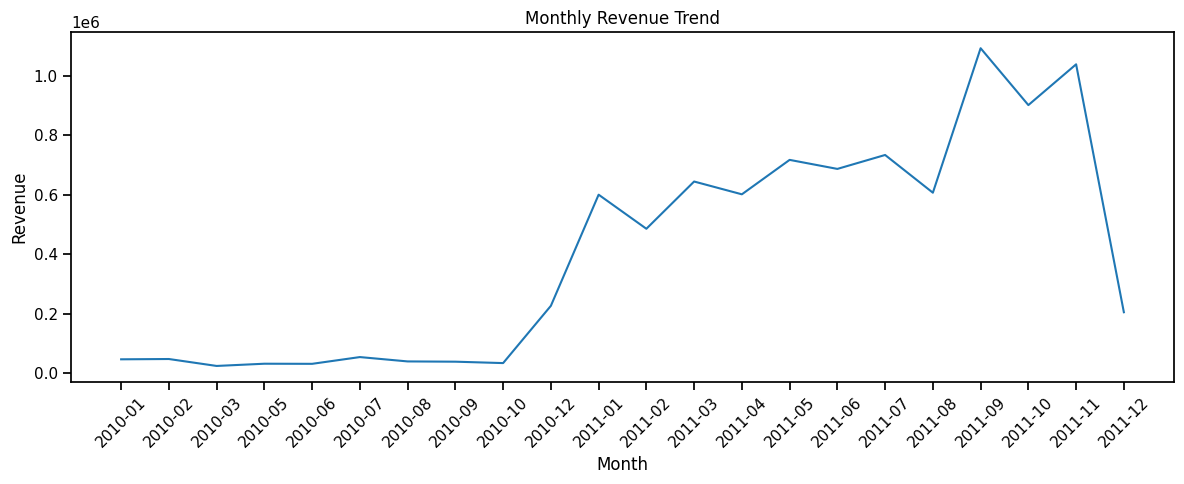

In [548]:
# Exploratory Analysis Part 1: Monthly Revenue Trend
# 1. Aggregate monthly revenue
monthly_revenue = (
    df_clean.groupby("InvoiceMonth", as_index=False)["Revenue"]
    .sum()
    .sort_values("InvoiceMonth")
)

monthly_revenue.head()

# 2. Plot monthly revenue
plt.figure(figsize=(12, 5))
plt.plot(monthly_revenue["InvoiceMonth"], monthly_revenue["Revenue"])
plt.xticks(rotation=45)
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()

## Monthly Revenue Trend — Interpretation

The monthly revenue trend shows a clear growth pattern over time, with a significant increase starting in late 2010 and sustained performance throughout 2011.

Revenue peaks during the second half of 2011, which may indicate seasonal effects such as increased demand during holiday periods.

The sharp decline observed in December 2011 is likely due to incomplete data for that month rather than an actual drop in business performance.

---

In [549]:
# Aggregate revenue by product
product_revenue = (
    df_clean.groupby("Description", as_index=False)["Revenue"]
    .sum()
    .sort_values("Revenue", ascending=False)
)

In [550]:
# Select Top 10 Products
top_10_products = product_revenue.head(10)
top_10_products

,Description,Revenue
2319,"PAPER CRAFT , LITTLE BIRDIE",168469.60
2767,REGENCY CAKESTAND 3 TIER,142264.75
3698,WHITE HANGING HEART T-LIGHT HOLDER,100392.10
1762,JUMBO BAG RED RETROSPOT,85040.54
1992,MEDIUM CERAMIC TOP STORAGE JAR,81416.73
2611,POSTAGE,77803.96
2345,PARTY BUNTING,68785.23
216,ASSORTED COLOUR BIRD ORNAMENT,56413.03
2130,Manual,53419.93
2656,RABBIT NIGHT LIGHT,51251.24


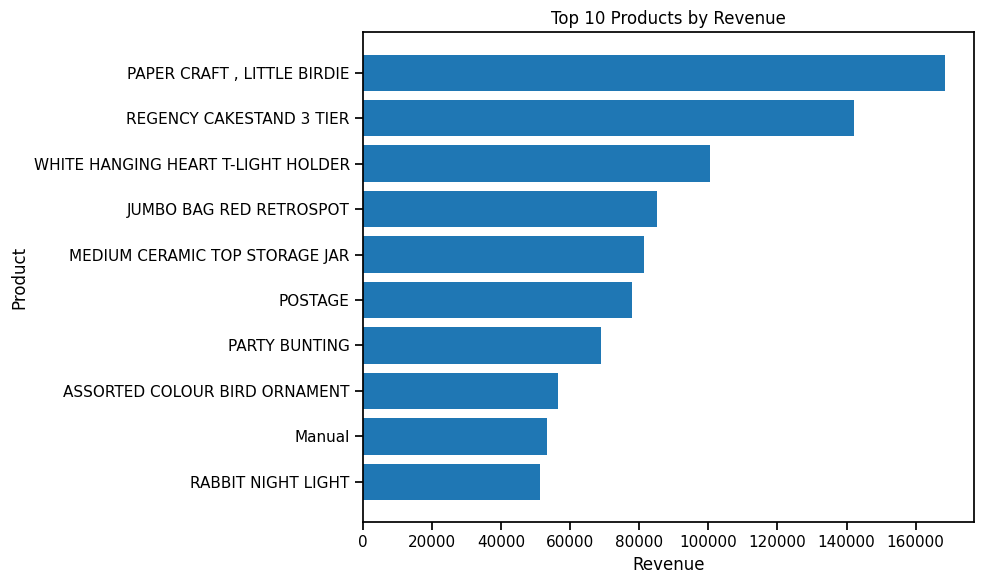

In [551]:
# Visualize Top 10 Products by Revenue using horizontal bar charts
plt.figure(figsize=(10, 6))
plt.barh(top_10_products["Description"], top_10_products["Revenue"])
plt.gca().invert_yaxis()  # Highest revenue at the top
plt.title("Top 10 Products by Revenue")
plt.xlabel("Revenue")
plt.ylabel("Product")
plt.tight_layout()
plt.show()

In [552]:
# Checking how much revenue the top 10 represents on overall
top_10_share = top_10_products["Revenue"].sum() / df_clean["Revenue"].sum()

print(f"Top 10 products revenue share: {top_10_share:.2%}")

Top 10 products revenue share: 9.96%


## Top Products by Revenue — Interpretation

The top 10 products contribute approximately 10% of total revenue, indicating that revenue is distributed across a wide range of products rather than being driven by a small set of top sellers.

This long-tail distribution suggests that maintaining a broad and diverse product catalog is important for overall revenue performance, and that inventory and demand planning should consider a large number of contributing SKUs rather than focusing only on a few best-selling items.

> Note: Some entries such as **POSTAGE** or **Manual** may represent non-product revenue items.  
> In a production setting, these would typically be analyzed separately or excluded from product performance analysis.

---

# 🌍 Country-Level Revenue Analysis
### Goals:
- Identify top revenue-generating countries;
- Understand geographic concentration;
- Support market prioritization decisions.

In [553]:
# Aggregate revenue by country
country_revenue = (
    df_clean.groupby("Country", as_index=False)["Revenue"]
    .sum()
    .sort_values("Revenue", ascending=False)
)

In [554]:
# Get Top 10 countries by revenue
top_10_countries = country_revenue.head(10)
top_10_countries

,Country,Revenue
35,United Kingdom,7285024.644
23,Netherlands,285446.340
10,EIRE,265262.460
14,Germany,228678.400
13,France,208934.310
0,Australia,138453.810
30,Spain,61558.560
32,Switzerland,56443.950
3,Belgium,41196.340
31,Sweden,38367.830


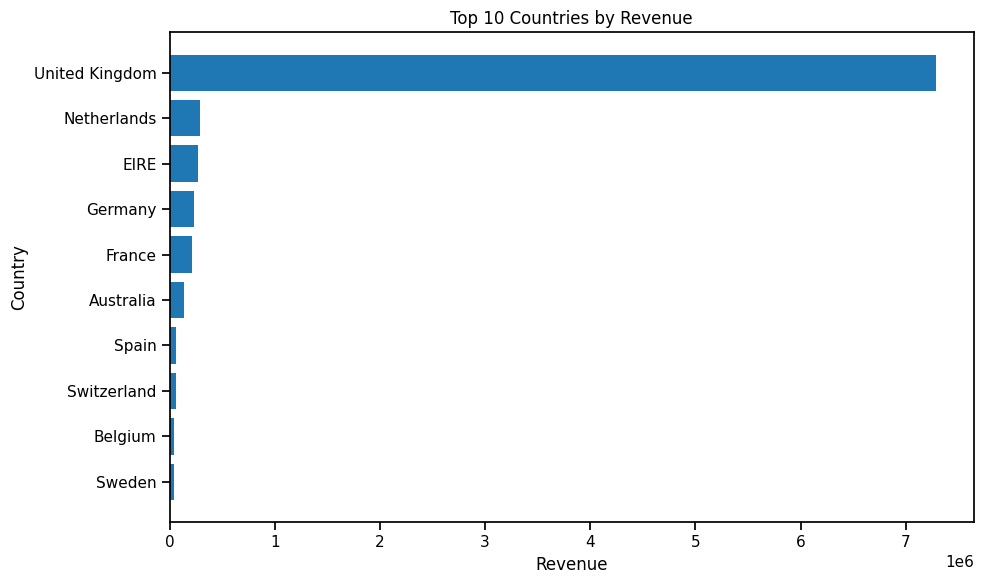

In [555]:
# Visualize Top Countries
plt.figure(figsize=(10, 6))
plt.barh(top_10_countries["Country"], top_10_countries["Revenue"])
plt.gca().invert_yaxis()
plt.title("Top 10 Countries by Revenue")
plt.xlabel("Revenue")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

In [556]:
# Revenue concentration by Top 1 country
top_country_share = (
    top_10_countries.iloc[0]["Revenue"] / df_clean["Revenue"].sum()
)

print(f"Top country revenue share: {top_country_share:.2%}")

Top country revenue share: 81.97%


## Revenue by Country — Interpretation

The analysis reveals a strong geographic concentration of revenue, with the United Kingdom accounting for approximately 82% of total sales.

This level of dependency indicates that overall business performance is highly sensitive to market conditions in the UK. While there is some international revenue, contributions from other countries remain relatively small, forming a long-tail distribution.

This insight highlights both a potential risk due to market concentration and an opportunity for growth through geographic expansion.

---

## Executive Summary

This project analyzed e-commerce transactional data to understand revenue trends, product performance, and geographic distribution.

- **Revenue trend:** Revenue increased significantly through 2011, with clear peaks and a lower final month consistent with partial-period data.
- **Product performance:** The top 10 products account for ~10% of revenue, indicating a **long-tail** product distribution.
- **Geography:** Revenue is highly concentrated in the **United Kingdom**, suggesting both market dependency risk and potential expansion opportunities.

---

## Limitations and Next Steps

- This analysis focuses on **revenue** and does not incorporate costs, returns handling policies, or profitability.
- Additional analyses that would add business value:
  - Customer segmentation (RFM)
  - Cohort/retention analysis
  - Profitability analysis (if cost data is available)
  - Anomaly detection for unusual transactions
